# Experiment Analysis

Dissecting model performance from training results -- e.g., visualizing the 
autoencoding/predictive ability. 

**Goals**: 
 - [ ] Load a model (use `src/execute_m2.py` loading code). 
 - [ ] Load some example data. 
 - [ ] Visualize unpatched version of the data. 
 - [ ] Visualize unpatched reconstruction and compare. 

In [13]:
## Import Box.
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math
import argparse
import datetime
import pickle
import pdb
import time
from packaging import version

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import imageio


sys.path.append('../../src')
import m2
import m1
import video_loader as vl
import video_preprocess as vp
import train_m2
import train_m1
import parallel_video_loader as pvl

In [14]:
## Constants
EXPERIMENT_FOLDER = '../debug/2022-11-18_15:09:55'
assert os.path.exists(EXPERIMENT_FOLDER)
num_frames = 100
mask_ratio = 0.3 # portion retained for input

## 1: Loading Experiment Results

### 1a: Retrieving Model Parameters

In [15]:
latest = None
if EXPERIMENT_FOLDER != None:
	latest = tf.train.latest_checkpoint(os.path.join(EXPERIMENT_FOLDER, 'checkpoints'))

latest2 = None 
if EXPERIMENT_FOLDER != None: 
	latest2 = tf.train.latest_checkpoint(os.path.join(EXPERIMENT_FOLDER, 'checkpoints2'))

In [16]:
# Load data (deserialize)
print("Restoring data args from checkpoint folder...")
data_args_path = os.path.join(EXPERIMENT_FOLDER, 'data_format_args.pkl')
with open(data_args_path, 'rb') as handle:
	data_format_args = pickle.load(handle)

# Now we unpack them, regardless of whether they were overwritten.
k_space = data_format_args['k_space']
mu_space = data_format_args['mu_space']
k_time = data_format_args['k_time']
mu_time = data_format_args['mu_time']
out_size = [int(i) for i in data_format_args['out_size']]
patch_height = data_format_args['patch_height']
patch_width = data_format_args['patch_width']
patch_duration = data_format_args['patch_duration']

data_format_args

Restoring data args from checkpoint folder...


{'k_space': 15,
 'mu_space': 20,
 'k_time': 64,
 'mu_time': 200,
 'out_size': ['120', '180'],
 'patch_height': 16,
 'patch_width': 16,
 'patch_duration': 1}

In [17]:
instant_param_pth = os.path.join(EXPERIMENT_FOLDER, 'instantiation_params.pkl')
with open(instant_param_pth, 'rb') as handle:
	instantiation_params = pickle.load(handle)

encoder_args = instantiation_params['encoder_args']
encoder_kwargs = instantiation_params['encoder_kwargs']

latent_ev_args = instantiation_params['latent_ev_args']
latent_ev_kwargs = instantiation_params['latent_ev_kwargs']

decoder_args = instantiation_params['decoder_args']
decoder_kwargs = instantiation_params['decoder_kwargs']

perceiver_kwargs = instantiation_params['perceiver_kwargs']

instantiation_params

{'encoder_args': [1],
 'encoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'latent_ev_args': [5],
 'latent_ev_kwargs': {'distinct_blocks': True,
  'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'decoder_args': [768, 3, 2],
 'decoder_kwargs': {'tfblock_residual': False,
  'n_heads': 15,
  'key_dim': 15,
  'mha_dropout': 0.0},
 'perceiver_kwargs': {'code_dim': 191, 'latent_dims': [100, 700]}}

### 1b: Re-instantiating Model & Yeeting In Params

In [18]:
# Instantiating the model using the loaded parameter lists/dicts. 
test_encoder = m2.PAE_Encoder(*encoder_args, **encoder_kwargs)

test_latent_ev = m2.PAE_Latent_Evolver(*latent_ev_args,**latent_ev_kwargs) 

test_decoder = m2.PAE_Decoder(*decoder_args, **decoder_kwargs)

code_dim = 2*(2*k_space+1) + (2*k_time+1) # k_space = 15 and k_time = 64 -> 191
mse = tf.keras.losses.MeanSquaredError()


perceiver_ae = m2.PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, **perceiver_kwargs)


Initialized latent_init successfully!!


In [19]:
# Inserting the checkpoint parameters. 
perceiver_ae.load_weights(latest)

## 2: Data Retrieval & Munging
 - Load the data (as in `execute_m2.py`).
 - Ensure function for going from patches $\to$ images works. 

In [20]:
print("\n\n\n\t==========================")
print("\t=== VIDEO LOADER SETUP ===")
print("\t==========================")

DATA_FOLDER = "../../datasets/downloads"
mp4_list = os.listdir(DATA_FOLDER)
path_list = [os.path.join(DATA_FOLDER, i) for i in mp4_list]

batch_size = 10
pool_size = 10
thread_per_vid = 1
num_prefetch=1
vid_generator = pvl.get_generator(path_list, out_size, num_frames, batch_size, 
			pool_size=pool_size, thread_per_vid=thread_per_vid)



videoset = tf.data.Dataset.from_generator(vid_generator, output_signature=tf.TensorSpec(shape=[batch_size, num_frames, *out_size, 3], dtype=tf.float16))
videoset = videoset.prefetch(num_prefetch)


print("\tMaking patches from Videoset...")
PatchSet = vp.make_patchset(videoset, patch_duration, patch_height, patch_width)
print("\tMaking the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)
print("\tAdding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))
print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)




	=== VIDEO LOADER SETUP ===
	Making patches from Videoset...
	Making the flat patch set...
	Adding codes to the PatchSet...
Flattening the coded + patched dataset...


## 3: Visualizing results for a few frames
 - Make sure the data has the proper codes (first 4 frames worth of codes are copy/pasted for all of them).
 - Visualize side-bys-side, generate a bunch of example plots. 

In [21]:
# PRELIMINARY: Getting the predictive training kwargs
predictive_param_path = os.path.join(EXPERIMENT_FOLDER, 'predictive_training_kwargs.pkl')
with open(predictive_param_path, 'rb') as handle:
	predictive_kwargs = pickle.load(handle)

alpha = predictive_kwargs['alpha']
present = predictive_kwargs['present_time_window']
future = predictive_kwargs['prediction_time_window']
predictive_kwargs

{'alpha': 0.7,
 'present_time_window': 1,
 'prediction_time_window': 3,
 'prob_prediction_select': 0.1}

### 3a: Making sure we can recover patched $\to$ original

In [22]:
# Get an element from FlatCodedPatchedSet and visualize it in real space (there should be a utility function for this...)
batch_ex = None
for x in FlatCodedPatchedSet: 
	batch_ex = x 
	break

# Get the corresponding element from videoset
source_ex = None
for x in videoset: 
	source_ex = x
	break

In [23]:
print("Batch example shape: ", batch_ex.shape)
print("Code dimension: ", code_dim)
print("Source video dimension: ", source_ex.shape)

Batch example shape:  (10, 7700, 959)
Code dimension:  191
Source video dimension:  (10, 100, 120, 180, 3)


In [24]:
# patch_height = data_format_args['patch_height']
# patch_width = data_format_args['patch_width']
# patch_duration = data_format_args['patch_duration']

n_time_patches = num_frames // patch_duration
n_height_patches = out_size[0] // patch_height
n_width_patches = out_size[1] // patch_width

print("Number of [time, height, width] patches:  ", (n_time_patches, 
			n_height_patches, n_width_patches))

unflattened_patched = vp.unflatten_patched(batch_ex[:,:,:-code_dim], n_time_patches, 
		n_height_patches, n_width_patches)

print("Unflattened patched: ", unflattened_patched.shape)

unflattened_8d = vp.make_3D_patches(unflattened_patched, patch_duration, patch_height, patch_width)
print("Unflattened 8D: ", unflattened_8d.shape)

unpatched = vp.get_vidtensor_from_8D(unflattened_8d)
print("Unpatched recovered tensor: ", unpatched.shape)


Number of [time, height, width] patches:   (100, 7, 11)
Unflattened patched:  (10, 100, 7, 11, 768)
Unflattened 8D:  (10, 100, 7, 11, 1, 16, 16, 3)
Unpatched recovered tensor:  (10, 100, 112, 176, 3)


Text(0.5, 0.98, 'Top: Original images; Bottom: Reconstructions from Patches')

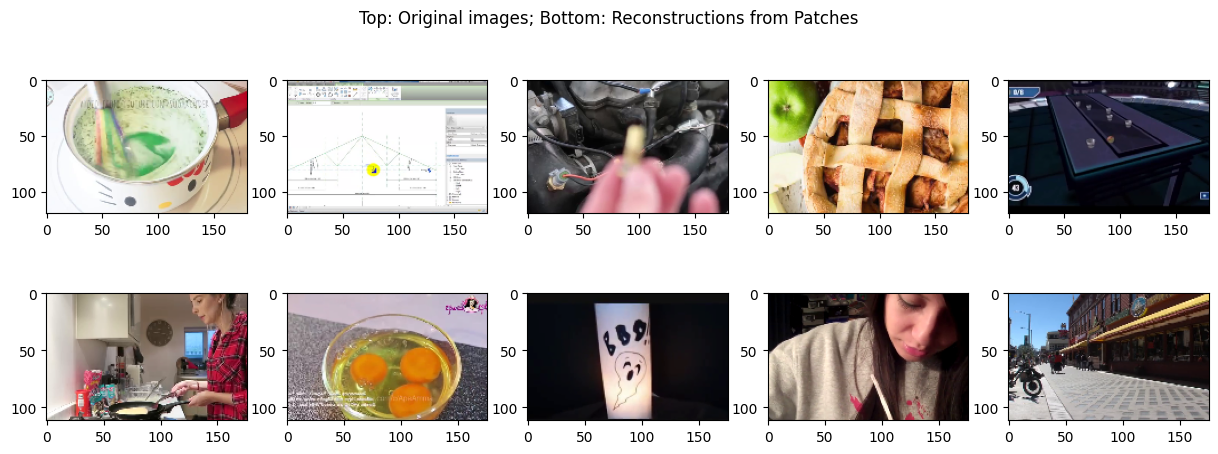

In [29]:
# Comparing to the original `batch_ex`...

fig, axs = plt.subplots(2, 5)
fig.set_figheight(5)
fig.set_figwidth(15)
frame_num = 20
batch_num = 2

for i in range(5): 
	plot_me_OG = source_ex[batch_num+i, frame_num, :, :, :]
	plot_me_reconstruction = unpatched[batch_num+i, frame_num, :, :, :]
	# print(plot_me_OG.dtype)
	# print(plot_me_reconstruction.dtype)
	ognp = plot_me_OG.numpy().astype(np.float32)
	ognp = cv2.cvtColor(ognp, cv2.COLOR_BGR2RGB)

	reconst = plot_me_reconstruction.numpy().astype(np.float32)
	reconst = cv2.cvtColor(reconst, cv2.COLOR_BGR2RGB)
	axs[0, i].imshow(ognp)
	axs[1, i].imshow(reconst)

fig.suptitle('Top: Original images; Bottom: Reconstructions from Patches')

### 3b: Running the Model on the Data

In [30]:
print("\n\n\n")
print("\t=======================")
print("\t=== TRAINING MODELS ===")
print("\t=======================")


## Calculating tokens per frame -- 
#  This is used to determine the present/future segments of interest. 
num_width = out_size[1] // patch_width
num_height = out_size[0] // patch_height

tokens_per_frame = (num_width * num_height)/patch_duration

present_tokens = round(tokens_per_frame * present)
future_tokens = round(tokens_per_frame * future)
super_el_tokens = round(tokens_per_frame * num_frames) # number of tokens in a batch element.
sub_el_tokens = present_tokens + future_tokens

print("Tokens per frame: ", tokens_per_frame)
print("Present no. tokens: ", present_tokens)
print("Future no. tokens: ", future_tokens)
print("Batch element no. tokens: ", super_el_tokens)





	=== TRAINING MODELS ===
Tokens per frame:  77.0
Present no. tokens:  77
Future no. tokens:  231
Batch element no. tokens:  7700


In [37]:
## Let's extract the codes for the first {present + future} tokens...
_el = None
for x in FlatCodedPatchedSet: 
	_el = x
	break

el = tf.constant(_el.numpy())

current_interval_codes = el[:,:sub_el_tokens,-perceiver_kwargs['code_dim']:]

# tf.profiler.experimental.start(train_log_dir)
perceiver_ae.reset_latent()
print("Model location (latent): ", perceiver_ae.latent.device)

present_mask = np.zeros([present_tokens], dtype=bool) # boolean mask
num_true = round(mask_ratio*present_tokens)
present_mask[:num_true] = True

future_mask = np.zeros([future_tokens], dtype=bool)
num_true = round(1.0 * future_tokens) # future selection probability -> 1.0
future_mask[:num_true] = True

print("Element shape: ", el.shape)

Model location (latent):  /job:localhost/replica:0/task:0/device:GPU:0
Element shape:  (10, 7700, 959)


## 

In [40]:
## Now let's sample the present and future tensors 
subcnt = 4 # the index of the time window (of size present+future) we are looking at within a batch of size `num_frames` frames
start_token = round(subcnt * tokens_per_frame) # token number representing the start of present
end_token = start_token + sub_el_tokens # sub_el_tokens is the number of tokens in the "present+future" time frame. 
print(f"Start token: {start_token}; \nEnd token: {end_token}; \nDifference: {end_token-start_token}; \nTokens per frame: {tokens_per_frame}; \nPresent time window (in frames): {present}; \nTokens in the present: {present_tokens}")

## Retrieving "super element" from the FlatPatchSet -- 
# we will take out the "present+future" time window from this and also add the positional codes from above.
el = None
for _super_el in FlatPatchSet:
	super_el = tf.constant(_super_el.numpy())
	el = super_el[:, start_token:end_token, :]
	el = tf.concat([el, current_interval_codes], 2)
	break

print(f"Element shape: {el.shape}")


Start token: 308; 
End token: 616; 
Difference: 308; 
Tokens per frame: 77.0; 
Present time window (in frames): 1; 
Tokens in the present: 77
Element shape: (10, 308, 959)


In [42]:
## Extracting the present and future tensors 
present = el[:, :present_tokens, :]
future = el[:, present_tokens:present_tokens+future_tokens, :]

np.random.shuffle(present_mask)
np.random.shuffle(future_mask)

present_sampled = tf.boolean_mask(present, present_mask, axis=1)
future_sampled = tf.boolean_mask(future, future_mask, axis=1)

print("Present sampled shape: ", present_sampled.shape)
print("Future sampled shape: ", future_sampled.shape)

Present sampled shape:  (10, 23, 959)
Future sampled shape:  (10, 231, 959)


In [ ]:
## Running the present and future thru the model 
blind_loss = perceiver_ae(present_sampled, reset_latent=True)
print("Blind loss: ", blind_loss)
cur_loss = model(present_sampled, remember_this=False)